In [51]:
import os 
import glob 

import numpy as np
import pandas as pd
from math import sqrt

from metpy.calc import wind_speed
from metpy.calc import wind_direction 
from metpy.units import units

import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D
import seaborn as sns
from upsetplot import UpSet, from_indicators

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set up working directory - adjust this to where the repo is stored locally
%cd '/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis'

/Users/patmccornack/Documents/ucsb_fog_project/_repositories/sci-wrf-analysis


# About
__Author:__ Pat McCornack

__Date:__ 12/09/24

__Description:__  
This notebook explores the relationship between different methods of inferring fog presence. These include the validation fog drip set collected using a fog harp, the fog deposition output from the WRF model which is based on liquid water content, and a radiation budget method based on the long-wave downwelling radiation output of WRF.

__Findings Summary:__  
Both the WRF fog deposition and radiation budget approach significantly underpredict fog compared to the validation set. We suspect that the WRF model underpredicts stratocumulus due to the parameterization of the boundary layer, which is likely leading to this result. Additionally, there is very low agreeance between inference methods - i.e. they infrequently identify fog at the same time. This could just be a matter of fog events being offset from each other - even if they have similar frequencies/timing. 

__Further Exploration:__  
Questions that warrant further investigation include:
1. How does the timing of fog events identified using different inference methods compare? Temporal heatmaps would be useful here.

__Note:__  
Development of this notebook has been paused, as it doesn't seem worth exploring when WRF is not predicting boundary layer conditions well. 

# Functions

In [43]:
def get_wind(u, v): 
    """"
    Calculates wind speed and direction from velocity components

    Parameters:
    -----------
    u : np.Series
        The x wind component.
    v : np.Series  
        The y wind component. 

    Returns:
    -----------
    wind_speed : float
        Calculated wind speed
    wind_dir : float
        Calculated wind direction 
    """
    u = u * units('m/s')
    v = v * units('m/s')

    wnd_spd = wind_speed(u,v)
    wnd_dir = wind_direction(u, v, convention='from')
    
    return wnd_spd, wnd_dir

def prep_data(df_fpath):
    """
    Reads and prepares data

    Reads in data, convert temperature from K to C, casts index to DateTime format, calculates
    wind speed and direction, and returns the prepared dataframe

    Parameters
    ----------
    df_fpath : str
        Path to file containing the data.
    
    Returns
    -------
    pd.Dataframe
        The prepared dataframe. 
    """
    df = pd.read_pickle(df_fpath)
    df['T2'] = df['T2'] - 273  # Convert K to C
    df.index = df.index - pd.Timedelta(hours=8)  # UTC to local
    wnd_spd, wnd_dir = get_wind(df['U10'].values, df['V10'].values)
    df['WND_SPD'] = wnd_spd
    df['WND_DIR'] = wnd_dir
    
    return df

# Read in and prepare data  

In [44]:
#### WRF data ####
datadir = './data/wrf-extracted/interpolated'
wsauc_fname = 'wrf-sauc-2003-2010.pkl'
wsauc_fpath = os.path.join(datadir, wsauc_fname)
wsauc = prep_data(wsauc_fpath)
wsauc.head()

,DFGDP,T2,Q2,PSFC,U10,V10,LWUPB,LWDNB,SWUPB,SWDNB,RH,WND_SPD,WND_DIR
times,,,,,,,,,,,,,
2002-06-30 16:00:00,0.0,16.739721,0.010619,98340.050281,1.872795,2.350064,0.000000,0.000000,0.000000,0.000000,87.413706,3.005023,218.551773
2002-06-30 17:00:00,0.0,18.949653,0.010380,98291.891475,-0.291864,0.210433,459.280270,334.343107,56.658686,387.258722,74.233599,0.359815,125.791428
2002-06-30 18:00:00,0.0,19.076010,0.010831,98242.852066,1.758425,-1.346994,443.047461,323.430480,31.885162,211.141588,76.805488,2.215051,307.452943
2002-06-30 19:00:00,0.0,17.662336,0.009881,98220.388056,1.893184,-1.578387,419.186600,315.142696,4.143514,25.954519,76.599042,2.464843,309.818659
2002-06-30 20:00:00,0.0,16.012562,0.009639,98229.194142,1.297025,-1.676641,402.394090,309.095212,0.000000,0.000000,83.041134,2.119764,322.274999


In [45]:
#### Observational data
odatadir = './data/observational'
osauc_fname = 'sauc-hourly.csv'
osauc = pd.read_csv(os.path.join(odatadir, osauc_fname))
osauc.set_index('time (PST)', inplace = True)
osauc.index = pd.to_datetime(osauc.index)
osauc.head()

,fog drip,rain (mm),wind gust (m/s),air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg)
time (PST),,,,,,,
2003-12-19 16:00:00,0.0,0.0,0.95,15.53,27.54,0.63,92.21
2003-12-19 17:00:00,0.0,0.0,3.96,15.22,27.05,1.40,99.26
2003-12-19 18:00:00,0.0,0.0,3.75,14.68,32.86,2.07,140.33
2003-12-19 19:00:00,0.0,0.0,3.51,12.89,60.68,2.22,122.58
2003-12-19 20:00:00,0.0,0.0,4.60,13.53,49.79,2.62,119.99


In [48]:
#### Create fog variable based on radiation ####
wsauc['rad_fog'] = wsauc['LWDNB'].apply(lambda x: 1 if x > 360 else 0)

#### Extract just fog variables ####
df = wsauc[['DFGDP', 'rad_fog']].join(osauc['fog drip'], how='inner')

### Convert all values to boolean and get agreement count
#df['DFGDP'] = df['DFGDP'].apply(lambda x: 1 if x > 0 else 0)
#df['fog drip'] = df['fog drip'].apply(lambda x: 1 if x > 0 else 0)
#df['count'] = df.sum(axis=1)

df.head(3)

,DFGDP,rad_fog,fog drip
2003-12-19 16:00:00,0.0,0,0.0
2003-12-19 17:00:00,0.0,0,0.0
2003-12-19 18:00:00,0.0,0,0.0


# Compare Fog Inference Methods
__rad_fog__ : Inference done using the radiation budget method described in [Impact of low cloud and fog on surface radiation fluxes for ecosystems in coastal California](https://doi.org/10.1007/s00704-021-03518-y). The long-wave downwelling radiation came from the WRF model. In short, if an observation has long-wave downwelling radation above 360 W/m^2 then that observation is labeled as Fog and Low Clouds. Note that this method does not distinguish between fog and low clouds, and would therefore be expected to overpredict fog. 

__DFGDP__: Fog deposition per time step extracted from the WRF model. This value was based on the model's liquid water content at the surface. 

__fog drip__: Fog drip at the site measured using a fog harp. This is the validation data set. Since not all fog events are productive, this is expected to underpredict the occurrence of fog. 

Note that this analysis makes no attempt to compare quantities of fog, just the presence.   


__Observations:__  
Both DFGDP and rad_fog underpredicted compared to the validation fog drip set, with rad_fog predicting slightly fewer events that DFGDP. The different inference methods did not agree in the majority of cases but it's possible they predict similarly, just offset. Based on other evidence we think that due to the parameterization in the boundary layer in WRF leads to the underprediction of stratocumulus clouds, and therefore fog - which is in line with the results that we're seeing here. 

<Figure size 1500x1500 with 0 Axes>

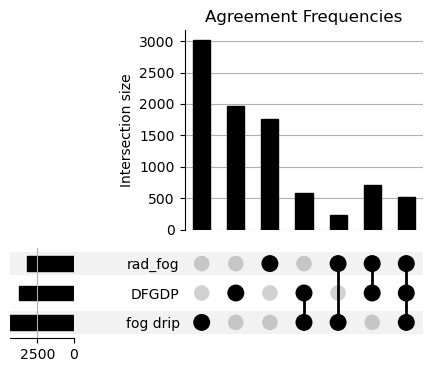

In [52]:
#### Make Upset Plot ####
bool_matrix = df.copy().reset_index()
bool_matrix = bool_matrix[['DFGDP', 'rad_fog', 'fog drip']].astype(bool)
bool_matrix = bool_matrix.loc[bool_matrix.any(axis=1)]  # Drops rows with all false
upset_data = from_indicators(['DFGDP', 'rad_fog', 'fog drip'], bool_matrix)
plt.figure(figsize=(15, 15))
UpSet(upset_data, subset_size='count').plot()
plt.title("Agreement Frequencies")
plt.show()